In [2]:
%%capture
!pip install roboflow ultralytics

# Import the necessary packages

In [3]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from random import sample
import pandas as pd
from ultralytics import YOLO
from roboflow import Roboflow
import shutil

# Preparing a custom dataset for YOLOv8

In [4]:
rf = Roboflow(api_key="ii6ocVMz9W9552bI5sBb")
project = rf.workspace("licence-plate-dswxt").project("license-plate-detection-lyvyv")
version = project.version(6)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.75, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to License-Plate-Detection-6 in yolov8:: 100%|██████████| 5089/5089 [00:00<00:00, 7926.38it/s]


In [5]:
working_dir = os.listdir(dataset.location)
print(working_dir)

['valid', 'README.roboflow.txt', 'test', 'train', 'data.yaml']


In [6]:
read_me = os.path.join(dataset.location,'README.roboflow.txt')
with open(read_me) as rf:
    content = rf.read()
print(content)


License Plate Detection - v6 2024-08-10 5:50pm

This dataset was exported via roboflow.com on August 10, 2024 at 5:50 PM GMT

Roboflow is an end-to-end computer vision platform that helps you
* collaborate with your team on computer vision projects
* collect & organize images
* understand and search unstructured image data
* annotate, and create datasets
* export, train, and deploy computer vision models
* use active learning to improve your dataset over time

For state of the art Computer Vision training notebooks you can use with this dataset,
visit https://github.com/roboflow/notebooks

To find over 100k other datasets and pre-trained models, visit https://universe.roboflow.com

The dataset includes 2539 images.
Workers are annotated in YOLOv8 format.

The following pre-processing was applied to each image:
* Auto-orientation of pixel data (with EXIF-orientation stripping)
* Resize to 720x360 (Stretch)

The following augmentation was applied to create 3 versions of each source imag

In [7]:
train_dir = os.path.join(dataset.location,'train')
print(os.listdir(train_dir))

train_images= os.path.join(train_dir,'images')
train_labels= os.path.join(train_dir,'labels')
print(train_images)
print(train_labels)

['labels', 'images']
/kaggle/working/License-Plate-Detection-6/train/images
/kaggle/working/License-Plate-Detection-6/train/labels


In [8]:
label_path = os.path.join(train_labels, os.listdir(train_labels)[0])
print(label_path)

with open(label_path) as rf:
    content = rf.read()  # Corrected method name
print(content)

/kaggle/working/License-Plate-Detection-6/train/labels/OD-09K-3933_jpg.rf.c2070aa456dc7d7b204cc0b85170d475.txt
0 0.30526809861481496 0.29822552571948224 0.13165582624080255 0.22893509215196797


In [9]:
def display_image(image, title="Image"):
    """Display the image using matplotlib."""
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 7), dpi=123)
    plt.imshow(rgb_image)
    plt.axis('off')
    plt.title(title)
    plt.show()

/kaggle/working/License-Plate-Detection-6/train/images/OD-02K-3076-2-_jpg.rf.546ca3a68373d5ec6c4d79807f2a64d3.jpg


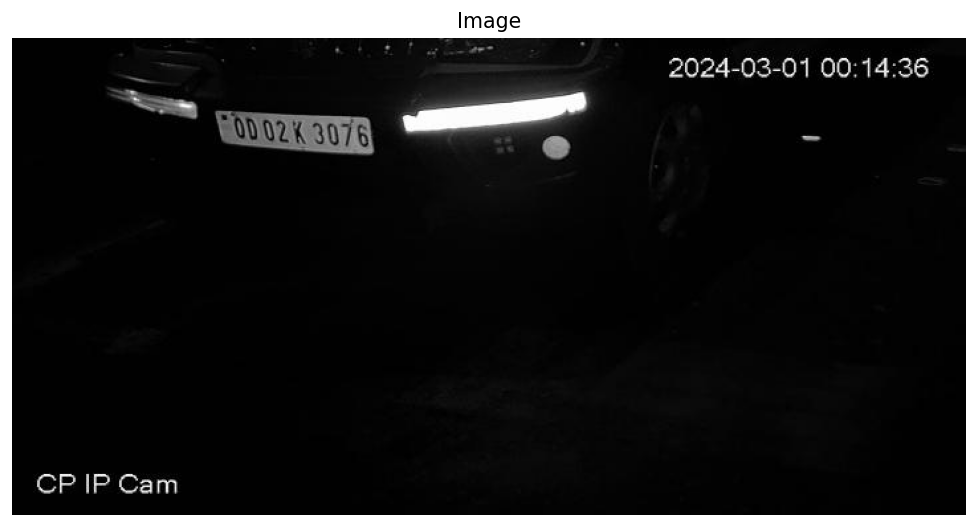

In [10]:
image_path=os.path.join(train_images,os.listdir(train_images)[523])
print(image_path)

image = cv2.imread(image_path)
display_image(image)

# Load a pretrained YOLO model (recommended for training)

In [11]:
# Load a pretrained YOLO model (recommended for training)
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 118MB/s]


In [12]:
res= model.predict(
    source=image_path,
    conf=0.25)


img= res[0].orig_img
res[0].summary


image 1/1 /kaggle/working/License-Plate-Detection-6/train/images/OD-02K-3076-2-_jpg.rf.546ca3a68373d5ec6c4d79807f2a64d3.jpg: 320x640 (no detections), 116.0ms
Speed: 9.2ms preprocess, 116.0ms inference, 84.5ms postprocess per image at shape (1, 3, 320, 640)


<bound method Results.summary of ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair',

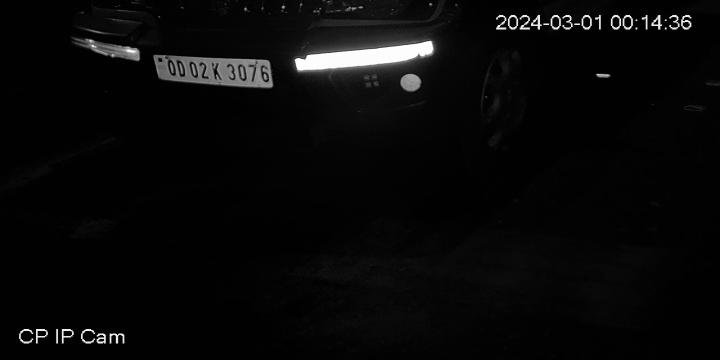

In [13]:
r = res[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

# Train YOLOv8 on a custom dataset

In [14]:
# Path to your data.yaml file
data_yaml_path = os.path.join(dataset.location,'data.yaml')
data_yaml_path

'/kaggle/working/License-Plate-Detection-6/data.yaml'

In [15]:
import yaml

# Load the data.yaml file
with open(data_yaml_path, 'r') as file:
    data = yaml.safe_load(file)

# Modify the paths as needed
data['train'] = '/kaggle/working/License-Plate-Detection-6/train/images'
data['val'] = '/kaggle/working/License-Plate-Detection-6/valid/images'

# Modify the number of classes and their names
data['nc'] = 1  # Number of classes
data['names'] = ['license_plate']  # List of class names

# Save the modified data.yaml file
with open(data_yaml_path, 'w') as file:
    yaml.dump(data, file)

In [16]:
results = model.train(
    data=data_yaml_path, 
    epochs=1, 
    project='Licence_plate',  # Project directory
    name='best_model'  # Subdirectory within the project directory
)

Ultralytics YOLOv8.2.75 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/License-Plate-Detection-6/data.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=Licence_plate, name=best_model, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=Fa

100%|██████████| 755k/755k [00:00<00:00, 27.7MB/s]
2024-08-10 18:41:03,395	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-08-10 18:41:04,377	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/License-Plate-Detection-6/train/labels... 2310 images, 75 backgrounds, 0 corrupt: 100%|██████████| 2310/2310 [00:01<00:00, 1334.84it/s]

train: New cache created: /kaggle/working/License-Plate-Detection-6/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
val: Scanning /kaggle/working/License-Plate-Detection-6/valid/labels... 200 images, 7 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1093.94it/s]


val: New cache created: /kaggle/working/License-Plate-Detection-6/valid/labels.cache
Plotting labels to Licence_plate/best_model/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to Licence_plate/best_model
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      2.39G       1.69      2.326      1.425         13        640: 100%|██████████| 145/145 [00:29<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.72it/s]


                   all        200        193      0.918      0.981       0.98      0.724

1 epochs completed in 0.012 hours.
Optimizer stripped from Licence_plate/best_model/weights/last.pt, 6.2MB
Optimizer stripped from Licence_plate/best_model/weights/best.pt, 6.2MB

Validating Licence_plate/best_model/weights/best.pt...
Ultralytics YOLOv8.2.75 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


                   all        200        193      0.918      0.981       0.98      0.724
Speed: 0.1ms preprocess, 1.1ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to Licence_plate/best_model


lr/pg0,▁
lr/pg1,▁
lr/pg2,▁
metrics/mAP50(B),▁
metrics/mAP50-95(B),▁
metrics/precision(B),▁
metrics/recall(B),▁
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,▁


# Load the trained model

In [17]:
# Define source and destination paths
source_dir = 'Licence_plate/best_model'
destination_dir = '/kaggle/working/Licence_plate'

os.makedirs(destination_dir, exist_ok=True)

files = os.listdir(source_dir)
# Move each file
for file_name in files:
    src_file = os.path.join(source_dir, file_name)
    dst_file = os.path.join(destination_dir, file_name)
    
    # Check if it's a file or directory and move accordingly
    if os.path.isfile(src_file):
        shutil.move(src_file, dst_file)
    elif os.path.isdir(src_file):
        shutil.move(src_file, dst_file)

In [18]:
from ultralytics import YOLO

trained_model = YOLO('/kaggle/working/Licence_plate/weights/best.pt')

# Predictions

In [20]:
test_dir = '/kaggle/working/License-Plate-Detection-6/test'
test_images=os.path.join(test_dir,'images')
img_path = os.path.join(test_images, os.listdir(test_images)[0])
results = trained_model(img_path)

print(results)


image 1/1 /kaggle/working/License-Plate-Detection-6/test/images/OR-05AP-5145_jpg.rf.11e609df5f19ca8172585da6f9b409de.jpg: 320x640 1 license_plate, 67.0ms
Speed: 1.7ms preprocess, 67.0ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'license_plate'}
obb: None
orig_img: array([[[ 8,  8,  8],
        [ 5,  5,  5],
        [ 4,  4,  4],
        ...,
        [20, 20, 20],
        [19, 19, 19],
        [19, 19, 19]],

       [[ 5,  5,  5],
        [ 4,  4,  4],
        [ 5,  5,  5],
        ...,
        [19, 19, 19],
        [19, 19, 19],
        [18, 18, 18]],

       [[ 6,  6,  6],
        [ 6,  6,  6],
        [ 7,  7,  7],
        ...,
        [19, 19, 19],
        [18, 18, 18],
        [17, 17, 17]],

       ...,

       [[ 1,  1,  1],
        [ 1,  1,  1],
        [ 1,  1,  1],
        ...,
        [ 1,  1,  1],
        [

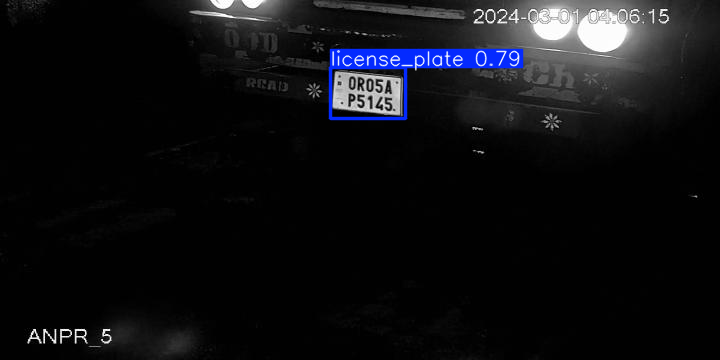

In [21]:
r = results[0]
im_array = r.plot()  # plot a BGR numpy array of predictions
im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
display(im)

# Validate the model

In [22]:
# Define directories
test_images_dir = '/kaggle/working/License-Plate-Detection-6/test/images'
test_labels_dir = '/kaggle/working/License-Plate-Detection-6/test/labels'

In [23]:
def load_labels(label_path):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:
                # Class ID, x_center, y_center, width, height
                labels.append([int(parts[0]), float(parts[1]), float(parts[2]), float(parts[3]), float(parts[4])])
    return labels

In [35]:
def evaluate_image(image_file):
    img_path = os.path.join(test_images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')
    label_path = os.path.join(test_labels_dir, label_file)

    # Load image
    img = cv2.imread(img_path)

    # Get model predictions
    results = trained_model(img_path)  # List of results
    predictions_df = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class'])
    
    if len(results) > 0:
        result = results[0]  # Get the first result
        boxes = result.boxes  # Get bounding boxes
        predictions = []
        if boxes is not None:
            for box in boxes.xyxy:
                if box is not None:
                    xmin = box[0].item() if len(box) > 0 and box[0] is not None else None
                    ymin = box[1].item() if len(box) > 1 and box[1] is not None else None
                    xmax = box[2].item() if len(box) > 2 and box[2] is not None else None
                    ymax = box[3].item() if len(box) > 3 and box[3] is not None else None
                    conf = box[4].item() if len(box) > 4 and box[4] is not None else None
                    class_id = int(box[5]) if len(box) > 5 and box[5] is not None else None

                    if xmin is not None and ymin is not None and xmax is not None and ymax is not None:
                        predictions.append([xmin, ymin, xmax, ymax, conf, class_id])
                        # Draw predicted bounding box in green
                        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 1)
            predictions_df = pd.DataFrame(predictions, columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class'])
    
    # Load ground truth labels
    ground_truth = load_labels(label_path) if os.path.exists(label_path) else []

    for gt in ground_truth:
        xmin, ymin, xmax, ymax = gt[:4]
        # Draw ground truth bounding box in yellow
        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0,255, 255), 5)
    
    # Print concise results
    print(f"Results for {image_file}:")
    print(f"Predictions (first 5 shown):\n{predictions_df.head()}")
    print(f"Ground Truth:\n{ground_truth[:5]}")  # Print only the first 5 ground truth labels

    # Display the image with bounding boxes
    display_image(img)

In [41]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
        box1 (list): [xmin, ymin, xmax, ymax] for the first box
        box2 (list): [xmin, ymin, xmax, ymax] for the second box
    
    Returns:
        float: IoU value
    """
    # Calculate the (x, y) coordinates of the intersection rectangle
    xA = max(box1[0], box2[0])
    yA = max(box1[1], box2[1])
    xB = min(box1[2], box2[2])
    yB = min(box1[3], box2[3])

    # Calculate the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Calculate the area of both bounding boxes
    box1Area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2Area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Calculate the intersection over union
    iou = interArea / float(box1Area + box2Area - interArea)

    return iou

In [44]:
def evaluate_image(image_file):
    img_path = os.path.join(test_images_dir, image_file)
    label_file = image_file.replace('.jpg', '.txt').replace('.png', '.txt')
    label_path = os.path.join(test_labels_dir, label_file)

    # Load image
    img = cv2.imread(img_path)

    # Get model predictions
    results = trained_model(img_path)  # List of results
    predictions_df = pd.DataFrame(columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class'])
    
    if len(results) > 0:
        result = results[0]  # Get the first result
        boxes = result.boxes  # Get bounding boxes
        predictions = []
        if boxes is not None:
            for box in boxes.xyxy:
                if box is not None:
                    xmin = box[0].item() if len(box) > 0 and box[0] is not None else None
                    ymin = box[1].item() if len(box) > 1 and box[1] is not None else None
                    xmax = box[2].item() if len(box) > 2 and box[2] is not None else None
                    ymax = box[3].item() if len(box) > 3 and box[3] is not None else None
                    conf = box[4].item() if len(box) > 4 and box[4] is not None else None
                    class_id = int(box[5]) if len(box) > 5 and box[5] is not None else None

                    if xmin is not None and ymin is not None and xmax is not None and ymax is not None:
                        predictions.append([xmin, ymin, xmax, ymax, conf, class_id])
                        # Draw predicted bounding box in green
                        cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
            predictions_df = pd.DataFrame(predictions, columns=['xmin', 'ymin', 'xmax', 'ymax', 'confidence', 'class'])
    
    # Load ground truth labels
    ground_truth = load_labels(label_path) if os.path.exists(label_path) else []

    ious = []
    for gt in ground_truth:
        # Convert ground truth from YOLO format (center_x, center_y, width, height) to bounding box format (xmin, ymin, xmax, ymax)
        gt_center_x = gt[1] * img.shape[1]
        gt_center_y = gt[2] * img.shape[0]
        gt_width = gt[3] * img.shape[1]
        gt_height = gt[4] * img.shape[0]

        gt_xmin = int(gt_center_x - gt_width / 2)
        gt_ymin = int(gt_center_y - gt_height / 2)
        gt_xmax = int(gt_center_x + gt_width / 2)
        gt_ymax = int(gt_center_y + gt_height / 2)

        # Draw ground truth bounding box in yellow
        cv2.rectangle(img, (gt_xmin, gt_ymin), (gt_xmax, gt_ymax), (0, 255, 255), 2)

        # Compare with predictions
        for _, pred in predictions_df.iterrows():
            pred_box = [pred['xmin'], pred['ymin'], pred['xmax'], pred['ymax']]
            gt_box = [gt_xmin, gt_ymin, gt_xmax, gt_ymax]
            iou = calculate_iou(pred_box, gt_box)
            ious.append(iou)
    
    # Print concise results
    print(f"Results for {image_file}:")
    print(f"Predictions (first 5 shown):\n{predictions_df.head()}")
    print(f"Ground Truth (first 5 shown):\n{ground_truth[:5]}")  # Print only the first 5 ground truth labels
    print(f"IoUs (first 5 shown):\n{ious[:5]}")  # Print first 5 IoUs

    # Display the image with bounding boxes
    display_image(img,'Labelled image')


image 1/1 /kaggle/working/License-Plate-Detection-6/test/images/OR-05AP-5145_jpg.rf.11e609df5f19ca8172585da6f9b409de.jpg: 320x640 1 license_plate, 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)
Results for OR-05AP-5145_jpg.rf.11e609df5f19ca8172585da6f9b409de.jpg:
Predictions (first 5 shown):
         xmin       ymin        xmax        ymax confidence class
0  330.965118  67.656967  405.510803  118.268478       None  None
Ground Truth (first 5 shown):
[[0, 0.5104166666666666, 0.2569444444444444, 0.10138888888888889, 0.13333333333333333]]
IoUs (first 5 shown):
[0.9287360070779305]


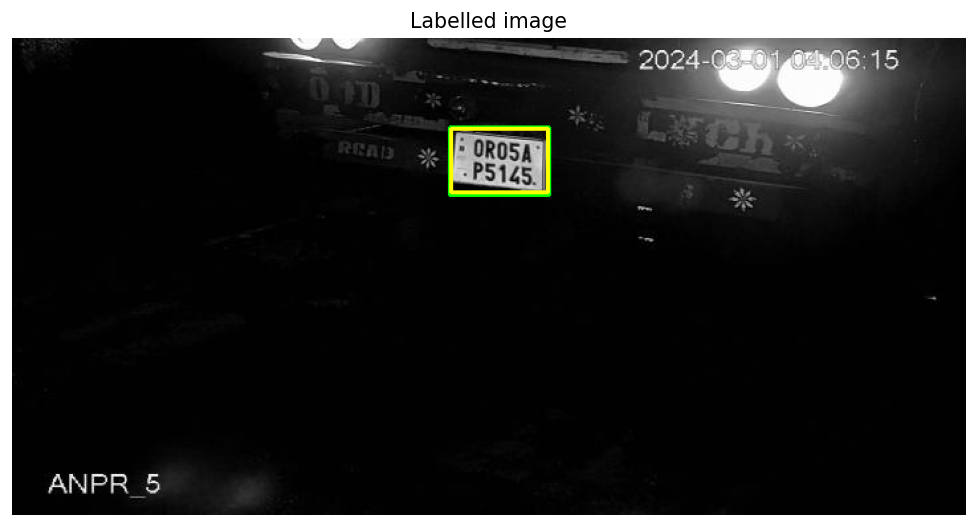


image 1/1 /kaggle/working/License-Plate-Detection-6/test/images/OD-02S-4541_jpg.rf.8bbb79b3347dc679122c9b978e4a91c3.jpg: 320x640 1 license_plate, 7.7ms
Speed: 2.3ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)
Results for OD-02S-4541_jpg.rf.8bbb79b3347dc679122c9b978e4a91c3.jpg:
Predictions (first 5 shown):
         xmin        ymin        xmax        ymax confidence class
0  159.639572  225.957947  244.821762  297.271332       None  None
Ground Truth (first 5 shown):
[[0, 0.2826388888888889, 0.7222222222222222, 0.12222222222222222, 0.22083333333333333]]
IoUs (first 5 shown):
[0.8737960741177343]


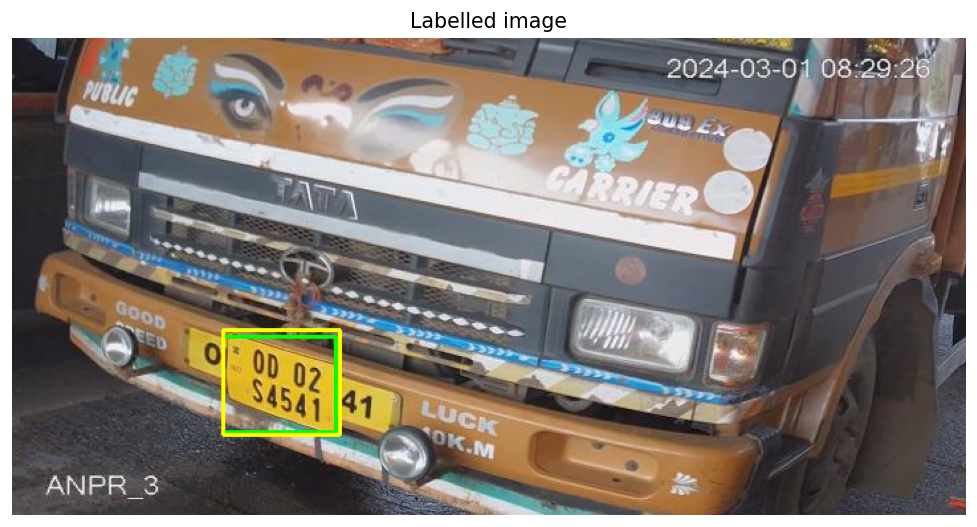


image 1/1 /kaggle/working/License-Plate-Detection-6/test/images/OD-05BK-8652_jpg.rf.bff25bec840a00d524e63f33cd733b99.jpg: 320x640 1 license_plate, 7.7ms
Speed: 1.5ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)
Results for OD-05BK-8652_jpg.rf.bff25bec840a00d524e63f33cd733b99.jpg:
Predictions (first 5 shown):
        xmin        ymin        xmax        ymax confidence class
0  58.773113  200.249237  144.911346  286.844299       None  None
Ground Truth (first 5 shown):
[[0, 0.1423611111111111, 0.6722222222222223, 0.11875, 0.24305555555555555]]
IoUs (first 5 shown):
[0.9505173985626683]


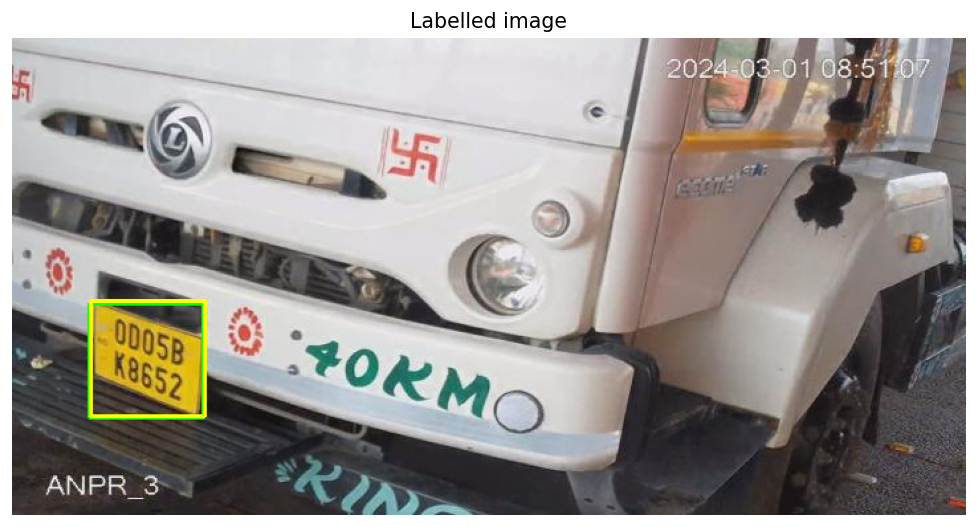


image 1/1 /kaggle/working/License-Plate-Detection-6/test/images/OD-02BB-9728_jpg.rf.6d7d348f84a0a840f189a50249c85cd5.jpg: 320x640 1 license_plate, 7.8ms
Speed: 1.5ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)
Results for OD-02BB-9728_jpg.rf.6d7d348f84a0a840f189a50249c85cd5.jpg:
Predictions (first 5 shown):
         xmin        ymin        xmax        ymax confidence class
0  180.995193  240.066544  305.501343  308.543365       None  None
Ground Truth (first 5 shown):
[[0, 0.3368055555555556, 0.7638888888888888, 0.17291666666666666, 0.19444444444444445]]
IoUs (first 5 shown):
[0.9590303025537018]


In [ ]:
# Evaluate all images
image_files = os.listdir(test_images_dir)

for image_file in image_files:
    evaluate_image(image_file)